### Import required libraries

In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch

import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import shap
from tensorflow import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [17]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
df.head().T

,0,1,2,3,4
0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
136,0.228077,0.476333,-0.532197,0.990133,0.960304
137,0.123431,0.773820,0.321097,1.086798,0.971020
138,0.925286,1.119621,0.904227,1.403011,1.614392
139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


In [18]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


In [19]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
136    0
137    0
138    0
139    0
140    0
Length: 141, dtype: int64

In [20]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
136    float64
137    float64
138    float64
139    float64
140    float64
Length: 141, dtype: object

In [21]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [22]:
# Step 3: Sample 250 from each class
class_0_sample = df[df['target'] == 0].sample(n=500, random_state=1)  # Sample from class 0
class_1_sample = df[df['target'] == 1].sample(n=500, random_state=1)  # Sample from class 1

# Step 4: Combine the samples into a new DataFrame
df = pd.concat([class_0_sample, class_1_sample], ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,target
0,-0.279995,-0.887037,-1.203541,-1.707776,-1.825967,-1.933866,-1.962609,-1.776699,-1.630844,-1.417339,...,-2.800794,-3.507024,-4.073475,-4.022491,-3.656692,-2.771562,-1.776220,-1.635745,-0.456314,0.0
1,-2.441627,-3.045965,-3.242639,-3.281584,-3.102492,-3.042163,-2.738071,-2.399656,-1.933064,-1.669117,...,-0.068216,-0.328677,-0.778780,-1.343103,-1.630426,-1.305564,-0.593929,-0.116210,0.187390,0.0
2,0.809519,-0.791838,-1.860487,-2.344264,-2.817237,-3.074113,-3.127174,-2.582324,-1.736323,-1.152413,...,-1.153233,-1.696939,-2.189026,-3.233398,-3.943029,-3.758904,-2.574293,-1.160786,-0.255077,0.0
3,-1.168922,-1.984521,-2.066480,-2.724717,-2.759475,-2.660823,-2.485859,-1.928450,-1.381274,-0.928753,...,-2.716674,-3.187462,-3.658988,-3.581469,-3.042979,-2.061724,-1.043356,-0.765439,0.425540,0.0
4,0.777507,-0.093521,-1.325974,-2.357312,-3.324888,-3.700024,-3.414683,-2.825427,-2.289683,-1.677639,...,1.516637,2.374123,2.519030,2.003930,1.526879,1.319077,1.541014,1.095894,0.677127,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-1.693663,-3.349918,-3.783739,-4.186651,-4.047209,-3.556076,-2.568456,-1.707440,-1.369048,-0.958154,...,1.266321,0.961309,0.403897,-0.029289,-0.376391,-0.558483,-0.245352,-0.110389,-1.563187,1.0
196,-0.943544,-2.474989,-4.040756,-4.569896,-4.263285,-3.599468,-2.205754,-1.441561,-1.208458,-0.499001,...,0.452088,0.392511,0.230906,0.268189,0.366888,0.659861,0.330095,-0.828240,-2.760391,1.0
197,-2.346512,-4.208884,-4.094278,-4.284980,-3.863157,-2.865434,-1.471617,-1.329882,-0.734054,-0.234076,...,0.709825,0.929761,1.090525,1.395176,1.240616,0.923225,0.722856,1.049785,0.589441,1.0
198,-0.042894,-1.868716,-3.333404,-4.580177,-4.165092,-3.172003,-2.145593,-1.800213,-1.378005,-0.615189,...,1.074354,1.196110,1.550111,1.674393,1.636101,1.251248,1.196408,1.663662,0.412128,1.0


In [23]:
df.target.value_counts()

target
0.0    100
1.0    100
Name: count, dtype: int64

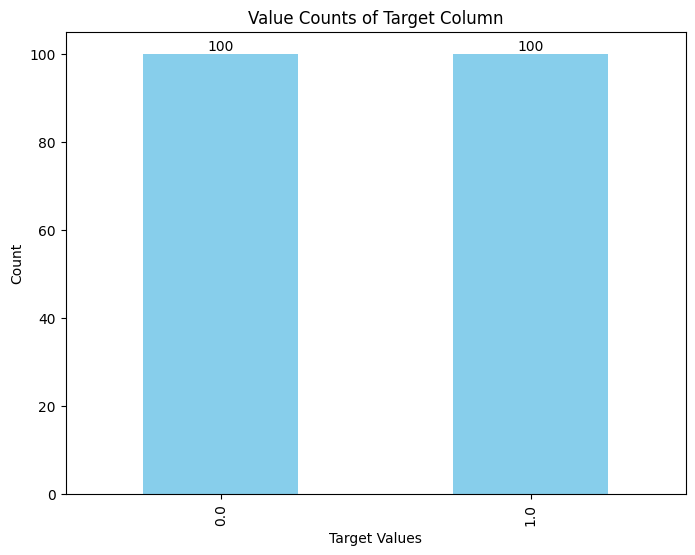

In [24]:
value_counts = df['target'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

# Display the count values on top of the bars
for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [25]:
classes = df.target.unique()

def plot_ecg(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='black', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    ax.set_title(class_name)

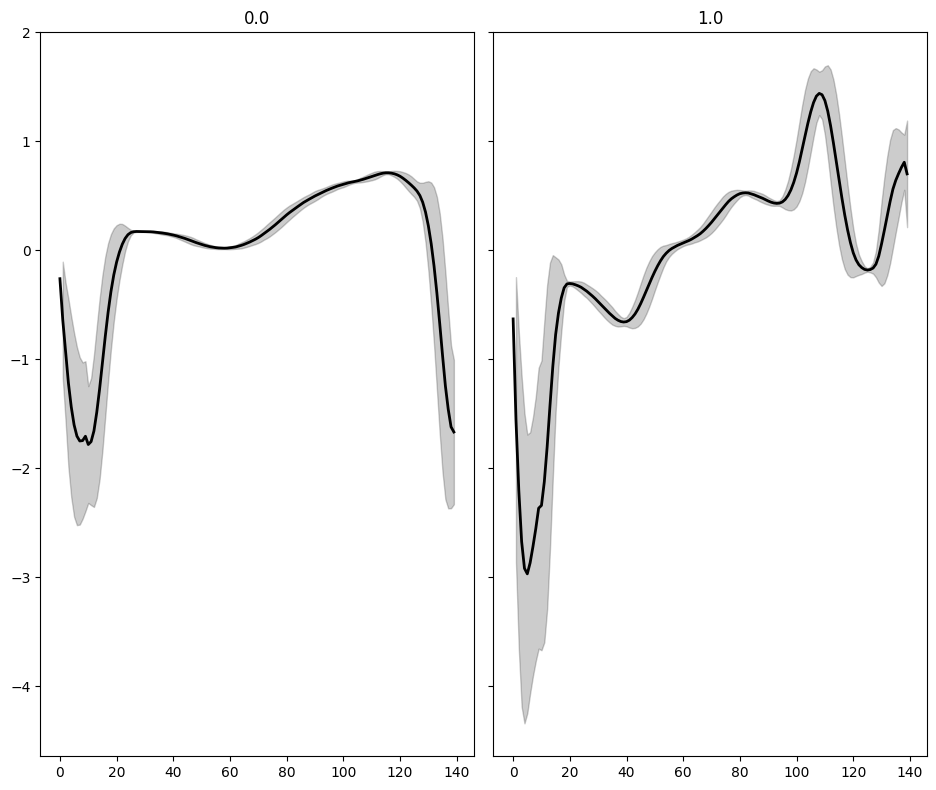

In [26]:
# Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_ecg(data, cls, ax)  # Using 'cls' directly as class name

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()

In [27]:
target_array = df['target'].to_numpy()  # Extracting the target column
features_array = df.drop(columns=['target']).to_numpy()

In [28]:
features_array = np.expand_dims(features_array, axis=-1)
features_array

array([[[-0.27999474],
        [-0.88703722],
        [-1.2035413 ],
        ...,
        [-1.7762197 ],
        [-1.6357448 ],
        [-0.45631431]],

       [[-2.4416272 ],
        [-3.0459647 ],
        [-3.2426392 ],
        ...,
        [-0.59392931],
        [-0.1162096 ],
        [ 0.18739045]],

       [[ 0.80951912],
        [-0.79183755],
        [-1.8604869 ],
        ...,
        [-2.5742929 ],
        [-1.1607856 ],
        [-0.2550769 ]],

       ...,

       [[-2.3465125 ],
        [-4.2088845 ],
        [-4.0942783 ],
        ...,
        [ 0.72285557],
        [ 1.0497848 ],
        [ 0.58944075]],

       [[-0.04289354],
        [-1.8687164 ],
        [-3.3334038 ],
        ...,
        [ 1.1964079 ],
        [ 1.663662  ],
        [ 0.41212773]],

       [[-0.82950832],
        [-3.3169622 ],
        [-4.4194624 ],
        ...,
        [ 1.3562523 ],
        [ 1.3157282 ],
        [-0.91614511]]])

In [29]:
target_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
features_array.shape

(200, 140, 1)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7805 - loss: 0.4562
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9784 - loss: 0.0666
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9859 - loss: 0.0647
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9706 - loss: 0.0840
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9858 - loss: 0.0508
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9847 - loss: 0.0540
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9842 - loss: 0.0474
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9825 - loss: 0.0529
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9827 - loss: 0.0678
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9924 - loss: 0.0352


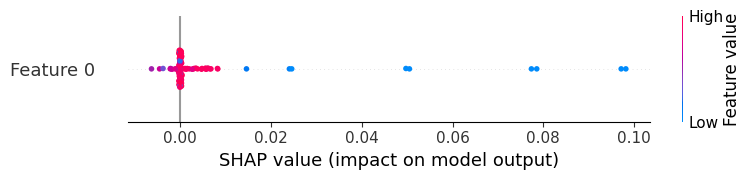

In [56]:

X = features_array
y = target_array

# Updated model with correct input shape
model = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(140,1)),  # LSTM layer with return sequences
    keras.layers.LSTM(128, return_sequences=False),  # Another LSTM layer
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')  # 3 output classes
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10)

# Use GradientExplainer with the model itself
explainer = shap.GradientExplainer(model, X)
shap_values = explainer.shap_values(X)

# specify class to explain
cls = 0

# specify data point to explain
idx = 0
shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

# We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
# Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

# Plotting the SHAP values for the given sample (idx) and class (cls)
# The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
shap.summary_plot(shap_values_for_sample, X[idx])

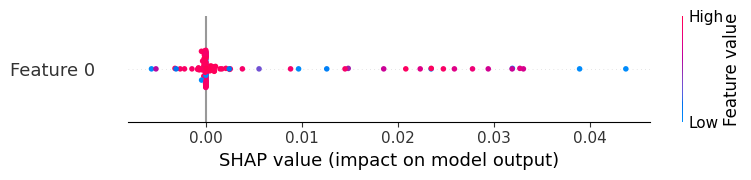

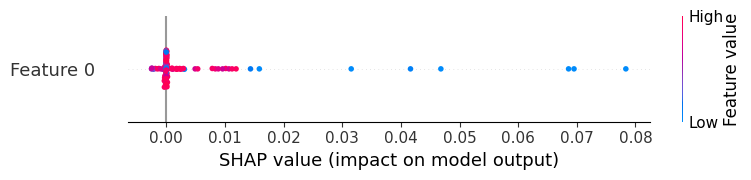

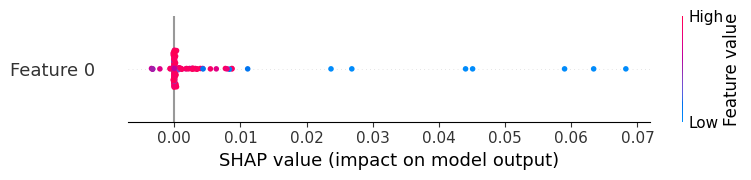

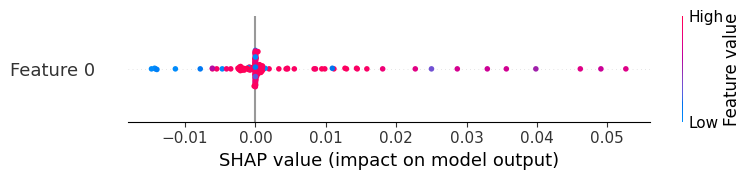

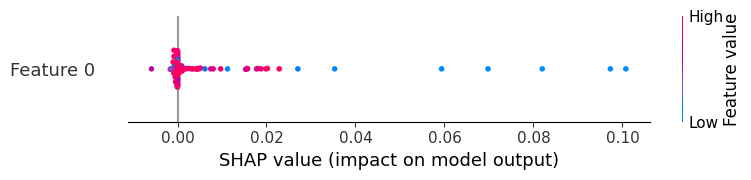

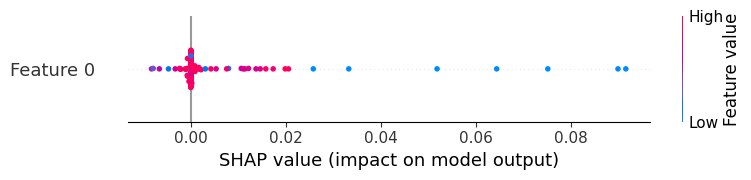

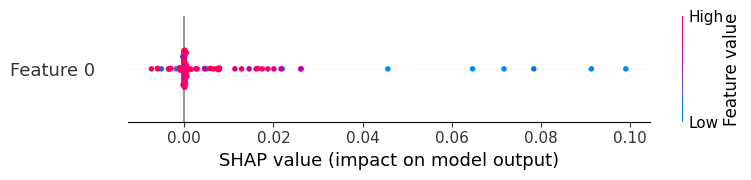

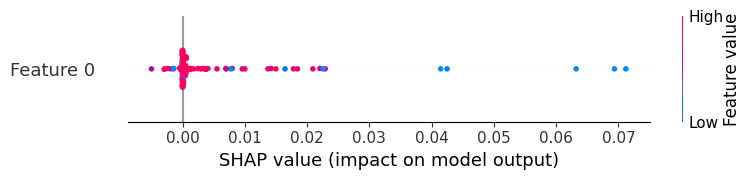

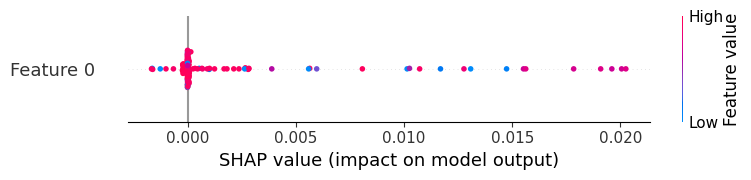

In [89]:
for i in range(1,10):    
    cls = i

    # specify data point to explain
    idx = 0
    shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

    # We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
    # Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
    shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

    # Plotting the SHAP values for the given sample (idx) and class (cls)
    # The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
    shap.summary_plot(shap_values_for_sample, X[idx])

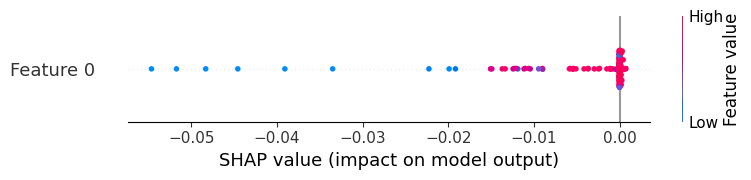

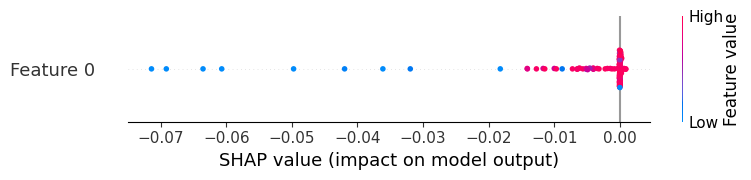

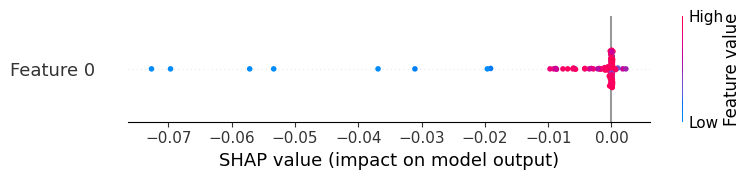

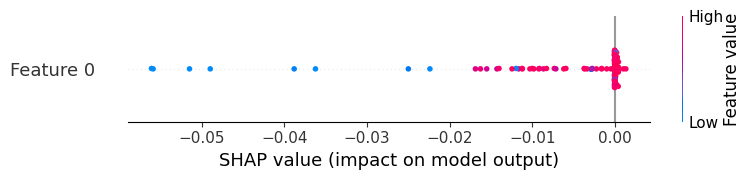

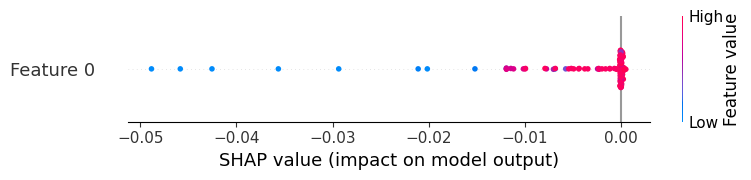

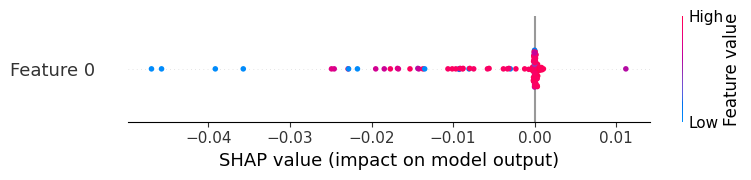

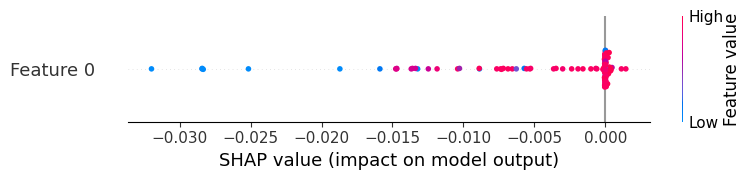

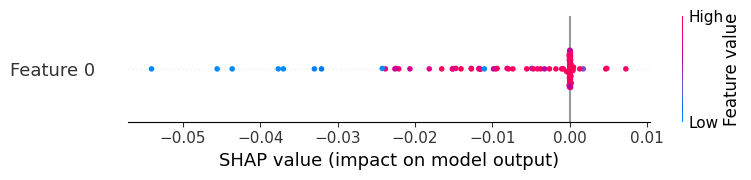

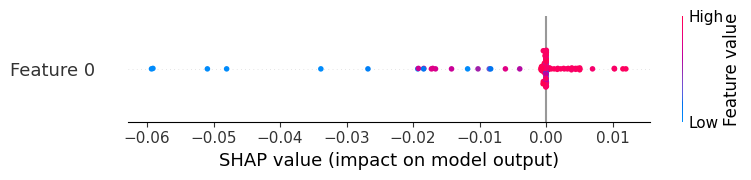

In [90]:
for i in range(501,510):    
    cls = i

    # specify data point to explain
    idx = 0
    shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

    # We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
    # Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
    shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

    # Plotting the SHAP values for the given sample (idx) and class (cls)
    # The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
    shap.summary_plot(shap_values_for_sample, X[idx])

In [16]:
from tensorflow.keras import layers, models
X = features_array
y = target_array
# Updated model with Bidirectional LSTM layers
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(140, 1)),  # Bidirectional LSTM layer
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),  # Another Bidirectional LSTM layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10)


Epoch 1/10


2024-12-15 19:05:51.216653: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.8698 - loss: 0.3583
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.9740 - loss: 0.0903
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.9806 - loss: 0.0498
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.9859 - loss: 0.0531
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9802 - loss: 0.0683
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9884 - loss: 0.0496
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9876 - loss: 0.0427
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9965 - loss: 0.0244
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9944 - loss: 0.0293
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9942 - loss: 0.0318


In [18]:
# Use GradientExplainer with the model itself
explainer = shap.GradientExplainer(model, X)
shap_values = explainer.shap_values(X)

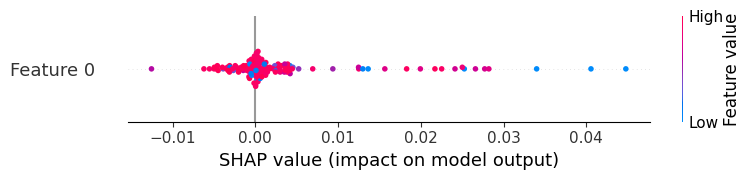

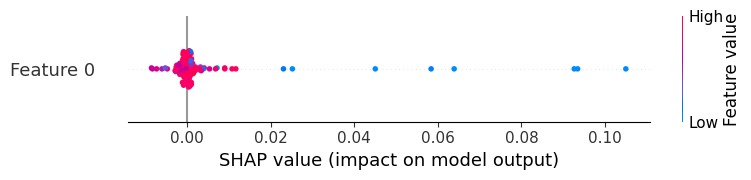

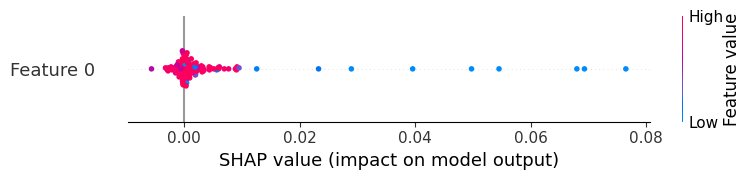

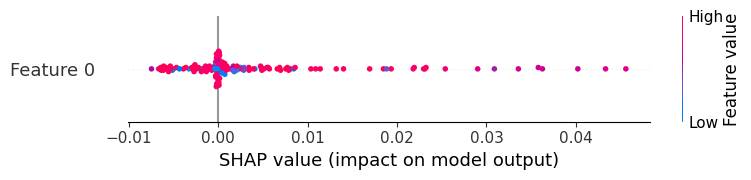

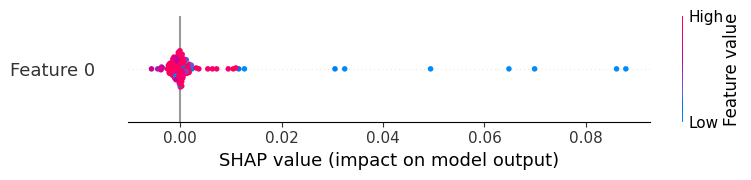

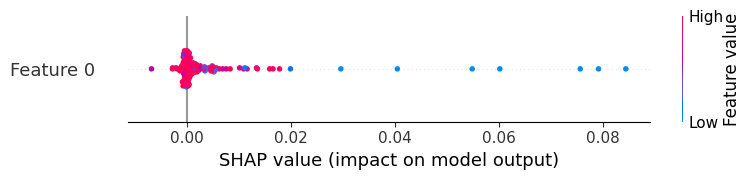

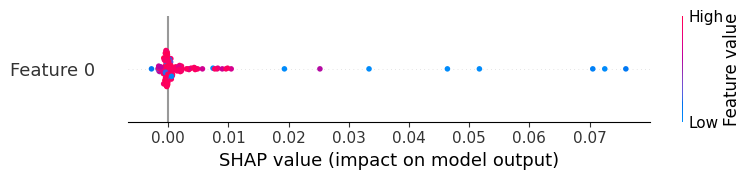

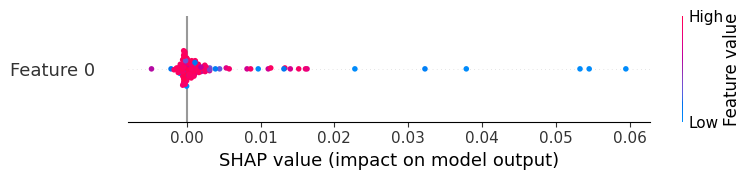

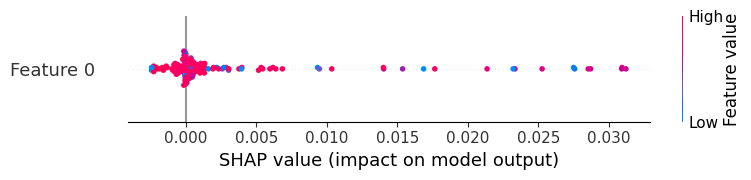

In [19]:
for i in range(1,10):    
    cls = i

    # specify data point to explain
    idx = 0
    shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

    # We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
    # Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
    shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

    # Plotting the SHAP values for the given sample (idx) and class (cls)
    # The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
    shap.summary_plot(shap_values_for_sample, X[idx])

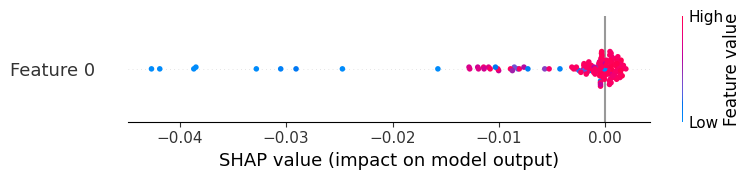

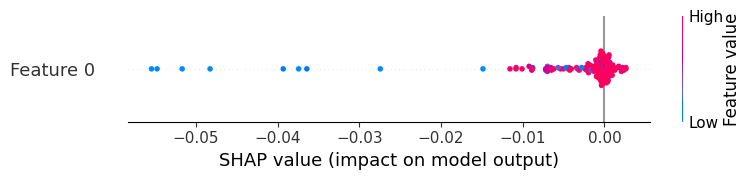

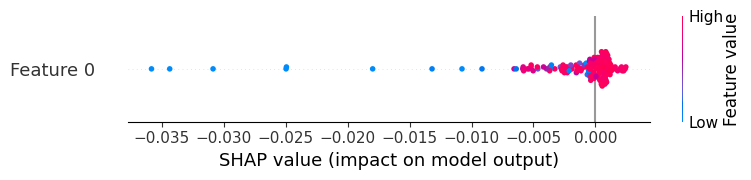

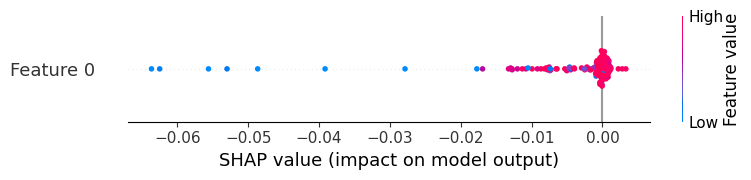

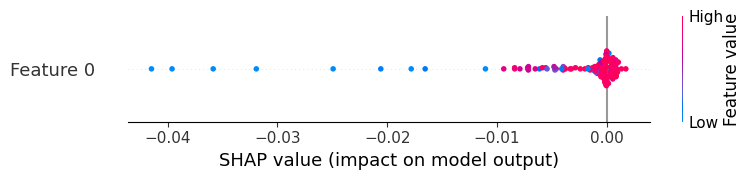

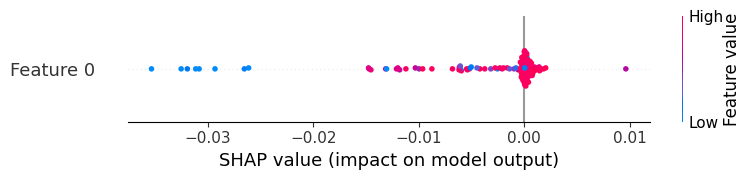

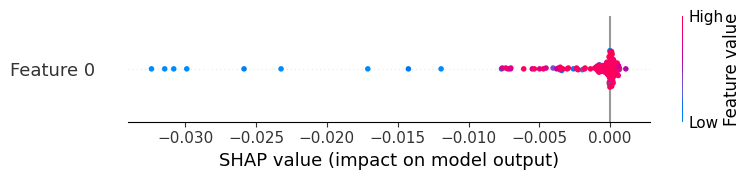

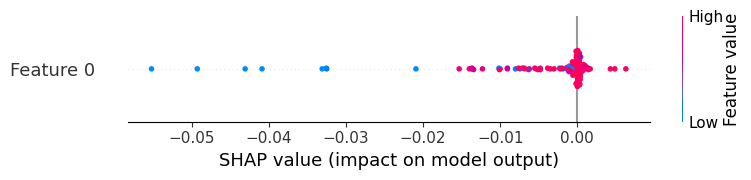

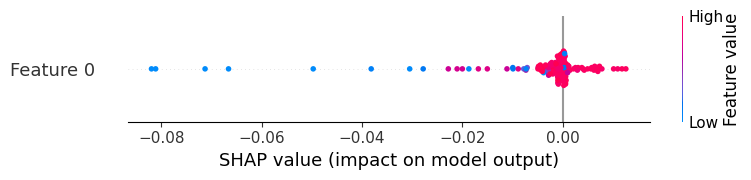

In [20]:
for i in range(501,510):    
    cls = i

    # specify data point to explain
    idx = 0
    shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

    # We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
    # Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
    shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

    # Plotting the SHAP values for the given sample (idx) and class (cls)
    # The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
    shap.summary_plot(shap_values_for_sample, X[idx])

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6353 - loss: 0.6290
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8770 - loss: 0.4054
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9117 - loss: 0.2867
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9242 - loss: 0.2175
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9826 - loss: 0.0753
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9931 - loss: 0.0332
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0188
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9973 - loss: 0.0143
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9904 - loss: 0.0258
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0085


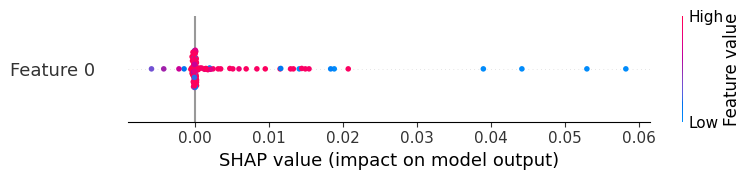

In [32]:
from tensorflow.keras import layers, models
X = features_array
y = target_array
# Updated model with CNN-LSTM architecture
model = models.Sequential([
    # Convolutional layer to extract features
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(140, 1)),  # 1D convolution
    layers.MaxPooling1D(pool_size=2),  # MaxPooling layer to reduce dimensions

    # LSTM layer to capture temporal dependencies
    layers.LSTM(128, return_sequences=False),  # LSTM layer
    layers.Flatten(),  # Flatten the output from LSTM
    
    # Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10)
# Use GradientExplainer with the model itself
explainer = shap.GradientExplainer(model, X)
shap_values = explainer.shap_values(X)

# specify class to explain
cls = 0

# specify data point to explain
idx = 0
shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

# We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
# Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

# Plotting the SHAP values for the given sample (idx) and class (cls)
# The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
shap.summary_plot(shap_values_for_sample, X[idx])


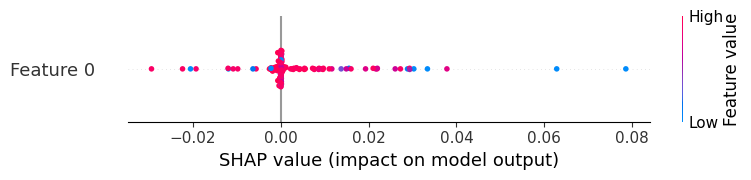

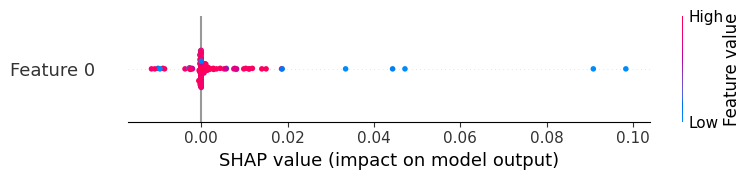

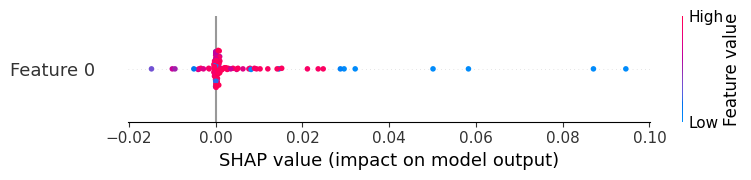

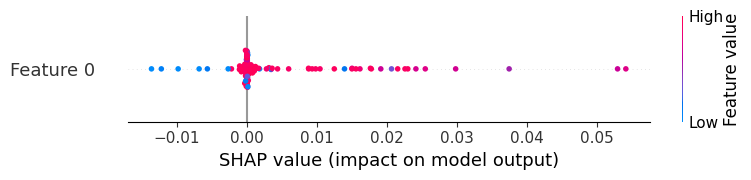

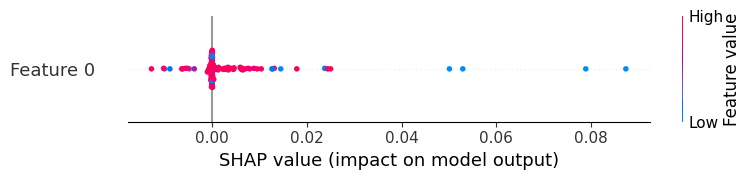

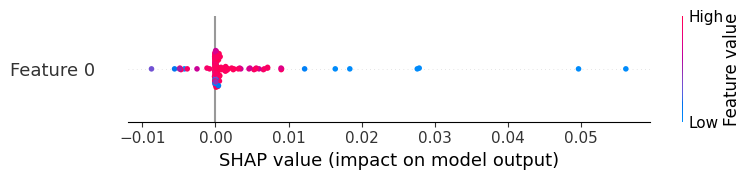

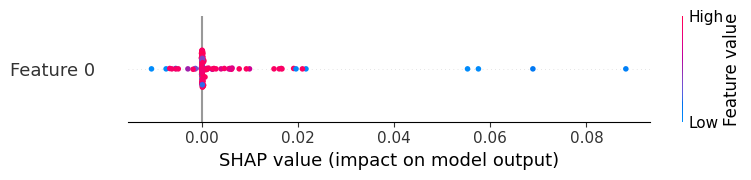

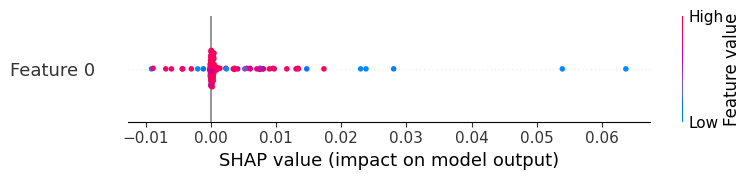

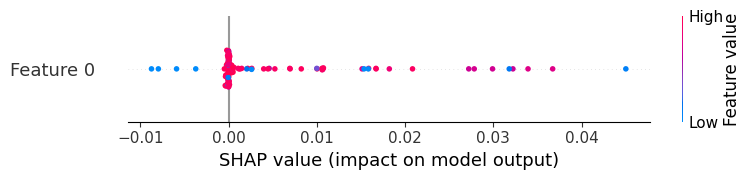

In [34]:
for i in range(1,10):    
    cls = i

    # specify data point to explain
    idx = 0
    shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

    # We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
    # Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
    shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

    # Plotting the SHAP values for the given sample (idx) and class (cls)
    # The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
    shap.summary_plot(shap_values_for_sample, X[idx])

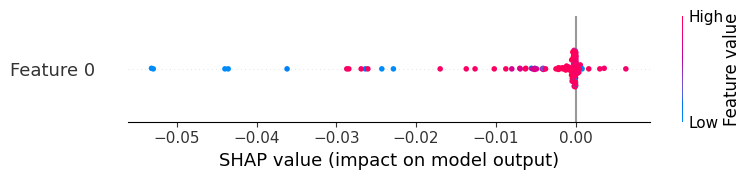

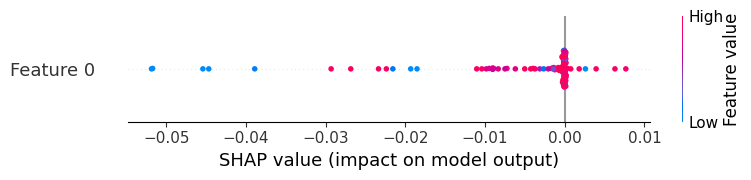

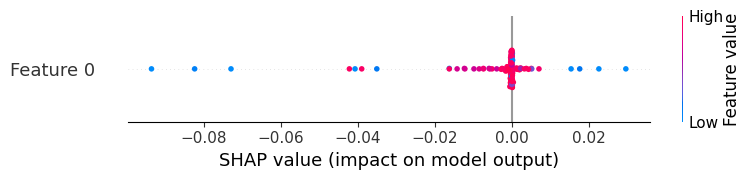

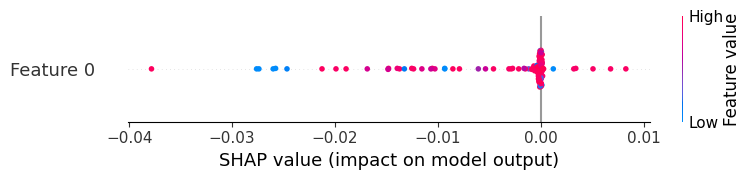

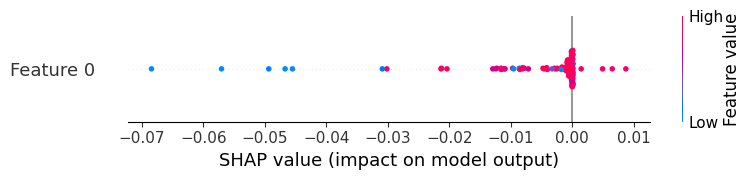

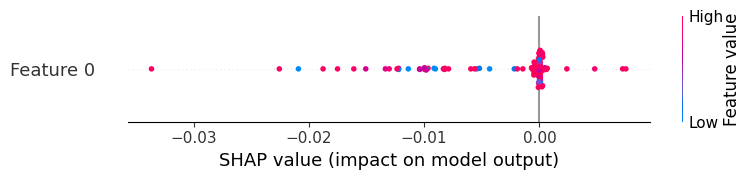

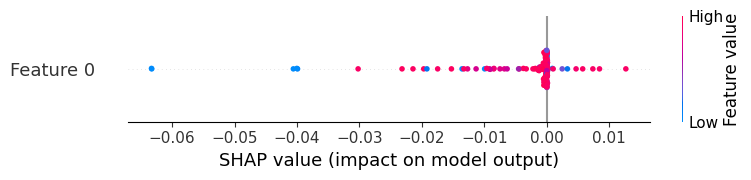

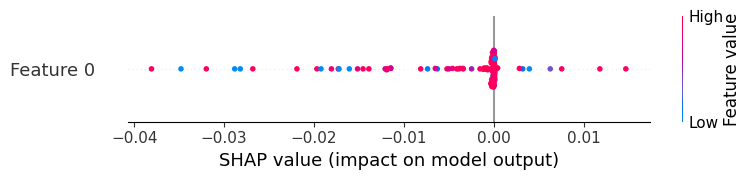

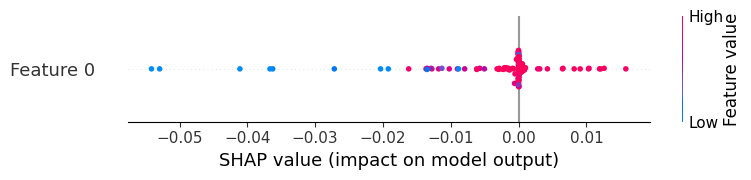

In [38]:
for i in range(501,510):    
    cls = i

    # specify data point to explain
    idx = 0
    shap_values_for_sample = shap_values[cls][:, idx, 0]  # SHAP values for class 0 and sample idx

    # We need to reshape shap_values_for_sample to match the shape of X[idx], which is (140, 1)
    # Currently, shap_values_for_sample has shape (140,). We need to reshape it to (140, 1) for the summary plot
    shap_values_for_sample = shap_values_for_sample.reshape(-1, 1)

    # Plotting the SHAP values for the given sample (idx) and class (cls)
    # The input data X[idx] has shape (140, 1) which matches the reshaped shap_values_for_sample
    shap.summary_plot(shap_values_for_sample, X[idx])